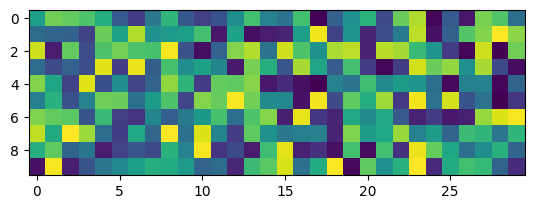

my function


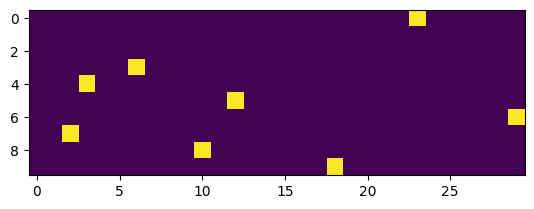

recursive fn


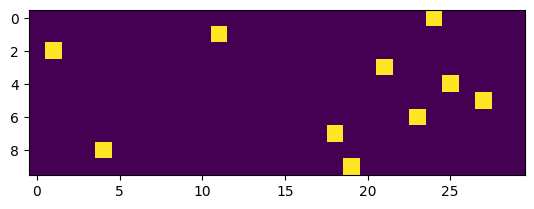

recursive fn2 


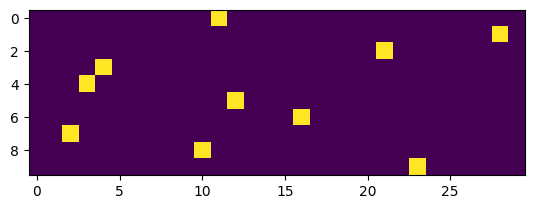

recursive fn5


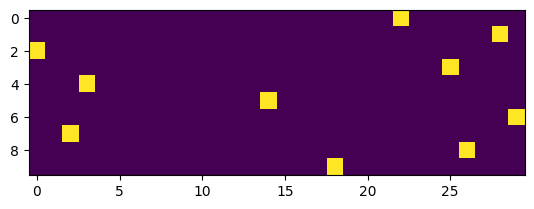

stock


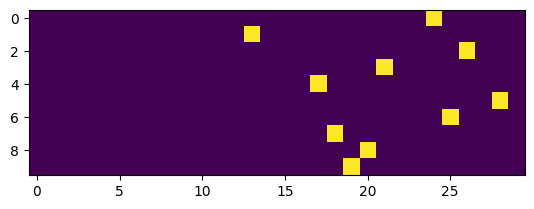

In [22]:
from Visualisations.lsafunctions import *
import torch
H=10
W=30
from matplotlib import pyplot as plt

TestTensor= torch.rand(H,W)

def draw(Tensor):
    plt.imshow(Tensor)
    plt.show()

draw(TestTensor)

functions= get_all_LSA_fns()
for name,fn in functions.items():
    print(name)
    draw(fn(TestTensor))

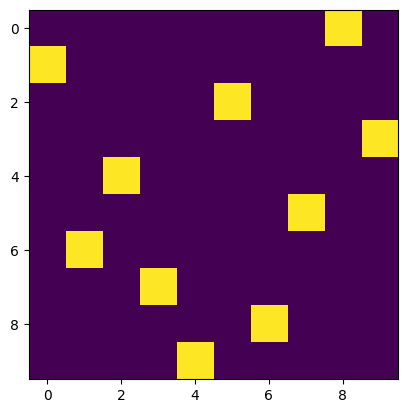

In [38]:
def recursiveLinearSumAssignment_v5(rewards:torch.Tensor,maximize=True,factor=10):
    #create tensor of ints
    output=torch.zeros_like(rewards,dtype=torch.int8)
    #print("out1")
    #draw(output)
    #cost_neg,next_highest_fn,comb_fn,final_fn=((1e9,torch.min,torch.add,torch.argmin),(-1e9,torch.max,torch.sub,torch.argmax))[maximize] 
    # remove=torch.zeros_like(rewards,dtype=torch.bool).fill_diagonal_(1).unsqueeze(0).repeat(*tuple([rewards.shape[-1]]+[1]*len(rewards.shape)))
    # col_index=None
    rewards=rewards.clone()
    dimsizes=torch.tensor(rewards.shape)
    #select index of the smallest value
    bigdim=torch.argmax(dimsizes)

    small_dim=torch.argmin(dimsizes)
    for i in range(10):
        cost2=reduceLinearSumAssignment_v2(rewards,maximize=maximize)
        rewards=rewards- (cost2/factor)# can remove
    
    #draw(output)
    #draw(rewards)
    cutoff=torch.topk(rewards.flatten(),rewards.shape[small_dim]+1,largest=maximize,sorted=True).values[-1]
    if maximize:
        output[(rewards>cutoff)]=1
    else:
        output[(rewards<cutoff)]=1
    return output


#now try on test tensor
TestTensor= torch.rand(10,10)
draw(recursiveLinearSumAssignment_v5(TestTensor,maximize=True,factor=1))


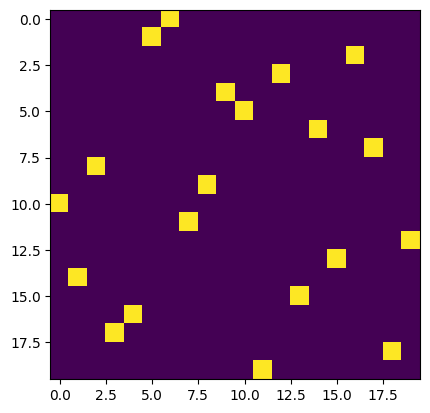

In [64]:

def MyLSA(TruthTensor, maximize=True,lookahead=2):
    '''
    If Maximize is False, I'm trying to minimize the costs. 
    This means that the mask must instead make all the weights far above all the others - 'inf' kind of thing. 
    '''
    #assert truthtensor is 2d and nonzero
    # assert len(TruthTensor.shape)==2
    # assert TruthTensor.shape[0]>0 and TruthTensor.shape[1]>0
    # assert lookahead>0
    # assert torch.sum(TruthTensor==0)==0

    mask=torch.zeros(TruthTensor.shape,device=TruthTensor.device,dtype=torch.int8)
    results=torch.zeros_like(TruthTensor)

    finder=torch.argmax if maximize else torch.argmin
    
    #subtract the min value from all values so that the min value is 0
    TruthTensor=TruthTensor-torch.min(torch.min(TruthTensor,dim=1,keepdim=True).values,dim=0).values
    replaceval=torch.tensor([float(-1)]) if maximize else torch.max(TruthTensor).to(dtype=torch.float32)+1

    dimsizes=torch.tensor(TruthTensor.shape)
    #select index of the smallest value
    bigdim=torch.argmax(dimsizes)   # 0 
    small_dim=1-bigdim          # 1

    for i in range(TruthTensor.shape[small_dim]): # number of rows 
        #print("masked input is: ")
        #draw(torch.where(mask==0,TruthTensor,replaceval))
        array=torch.where(mask==0,TruthTensor,replaceval)
        deltas=torch.diff(torch.topk(array,lookahead,dim=bigdim,largest=maximize).values,n=lookahead-1,dim=bigdim).squeeze()
        #print(deltas)
        #draw(deltas.unsqueeze(1))
        col_index=torch.argmax(torch.abs(deltas)) # this is the column to grab,  Note this measures step so its not important to do argmin...
        #print(str(col_index.item()) + " selected ")
        if small_dim==1:
            row_index=finder(array[:,col_index]) 
            results[row_index,col_index]=1
            mask[:,col_index]=1 #mask out the column 
            mask[row_index]=1
        else: 
            row_index=finder(array[col_index])
            #now we have to swap the row and column index 
            # results[col_index,row_index]=1
            results[col_index,row_index]=1

            mask[:,row_index]=1 #mask out the column 
            mask[col_index]=1
        #results[row_index,col_index]=1
        #print("mask is now")
        #draw(mask)
    return results

TestTensor= torch.rand(20,20)
draw(MyLSA(TestTensor,maximize=True,lookahead=2))